In [ ]:
# Copyright (c) 2022, Gonzalo Ferrer, Dmitrii Iarosh, Anastasiia Kornilova
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import copy
import pickle
import mrob
import numpy as np
import open3d as o3d
import os
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from dataset_loaders.CameraParameters import CameraParameters
from dataset_loaders.IclTumCompatLoader import IclTumCompatLoader

from plane_extractor.plane_extractor import extract_planes_from_pcd_colors

from plane_backends.solver_factory import create_solver_by_name

from metrics.rpe import rpe
from metrics.ape import ape

from perturbation.perturbation import Perturbation, generate_random_pose_shift

In [3]:
def get_map(pcds, Ts):
    map_pcd = o3d.geometry.PointCloud()
    i = 0
    for pcd, T in zip(pcds, Ts):
        map_pcd += copy.deepcopy(pcd).transform(T)
        map_pcd = map_pcd.voxel_down_sample(0.03)

    return map_pcd

### Load ICL data with planes

In [4]:
depth_data_path = 'depth'
label_data_path = 'labels'

In [5]:
depth_paths = [f for f in Path(depth_data_path).iterdir() if f.is_file()]
label_paths = [f for f in Path(label_data_path).iterdir() if f.is_file()]

# Order depth and labels by timestamps
frame_timestamps = [int(file.split('.')[0]) for file in os.listdir(depth_data_path)]
depth_paths = [depth_paths[i] for i in np.argsort(frame_timestamps)]
label_paths = [label_paths[i] for i in np.argsort(frame_timestamps)]

In [6]:
# Taken from https://www.doc.ic.ac.uk/~ahanda/VaFRIC/codes.html
camera_parameters = CameraParameters(
    width=640,
    height=480,
    cx=319.50,
    cy=239.50,
    fx=481.20,
    fy=-480.00,
    scale=5000,
)

loader = IclTumCompatLoader(camera_parameters)

In [7]:
pcds = []
observations = []

OBSERVATIONS_COUNT = 100

for i in tqdm(range(1, OBSERVATIONS_COUNT)):
    pcd = loader.load_point_cloud(depth_paths[i], label_paths[i])
    pcds.append(pcd)
    # Plane labels are stored as colors of pcd (single color --- single plane)
    color_to_points = extract_planes_from_pcd_colors(pcd)
    observations.append(color_to_points)

100%|██████████| 99/99 [00:38<00:00,  2.58it/s]


### Load gt poses

In [9]:
def read_poses_icl_tum_compat(traj_path):
    poses_quaternions = []
    with open(traj_path, 'r') as file:
        for line in file:
            poses_quaternions.append([float(i) for i in line.strip().split(' ')])

    transform_matrices = []
    for i, pose in enumerate(poses_quaternions):
        translation = pose[1:4]
        rotation = mrob.geometry.quat_to_so3(pose[4:8])
        transform_matrix = np.eye(4)
        transform_matrix[:3, :3] = rotation
        transform_matrix[:3, 3] = translation
        transform_matrices.append(transform_matrix)

    return transform_matrices

In [10]:
gt_poses = read_poses_icl_tum_compat('livingRoom0.gt.freiburg')
# Remap poses as the first pose is the origin point
gt_poses = [np.linalg.inv(gt_poses[0]) @ pose for pose in gt_poses]

print(f"Loaded {len(gt_poses)} poses")

Loaded 1508 poses


### Evaluate APE and RPE

In [11]:
def save_data_for_balm(pcds, gt_poses, perturbed_poses, folder_name):
    os.mkdir(folder_name)
    for i, pcd in enumerate(pcds):
        o3d.io.write_point_cloud(os.path.join(folder_name, f'{i}.pcd'), pcd)

    with open(os.path.join(folder_name, 'gt_poses.pkl'), 'wb') as f:
        pickle.dump(gt_poses, f)

    with open(os.path.join(folder_name, 'pert_poses.pkl'), 'wb') as f:
        pickle.dump(perturbed_poses, f)

In [12]:
solvers = [
    'bareg',
    'pi-factor',
    'ef-centered',
]

df_stat = pd.DataFrame()
perturbations = [
    Perturbation(rotation_shift=1, translation_shift=0.01),
    Perturbation(rotation_shift=5, translation_shift=0.05),
    Perturbation(rotation_shift=10, translation_shift=0.1),
    Perturbation(rotation_shift=15, translation_shift=0.15),
    Perturbation(rotation_shift=20, translation_shift=0.2),
]

ind = 0
SEQUENCE_SIZE = 10
SEQUENCES_COUNT = 50
for perturbation in perturbations:
    for sequence_index in tqdm(range(SEQUENCES_COUNT)):
        start = np.random.randint(0, OBSERVATIONS_COUNT - SEQUENCE_SIZE)
        sequence_gt_poses = gt_poses[start:start + SEQUENCE_SIZE]
        sequence_observations = observations[start:start + SEQUENCE_SIZE]

        perturbed_poses = []
        for i, _ in enumerate(sequence_gt_poses):
            perturbed_poses.append(
                sequence_gt_poses[i] @ generate_random_pose_shift(
                    perturbation.rotation_shift / 180 * np.pi,
                    perturbation.translation_shift
                )
            )
        name = '_'.join(
            [
                str(SEQUENCE_SIZE),
                str(sequence_index),
                str(perturbation.rotation_shift),
                str(perturbation.translation_shift)
            ]
        )

        save_data_for_balm(pcds[start:start + SEQUENCE_SIZE], sequence_gt_poses, perturbed_poses, name)

        for solver_name in solvers:
            solver = create_solver_by_name(solver_name, iterations_count=300)
            refined_poses, _, _ = solver.solve(sequence_observations, perturbed_poses)
            ape_translation, ape_rotation = ape(sequence_gt_poses, refined_poses[:SEQUENCE_SIZE])
            rpe_translation, rpe_rotation = rpe(sequence_gt_poses, refined_poses[:SEQUENCE_SIZE])
            stat = {
                'solver': solver_name,
                'sample': sequence_index,
                'pose_perturbation': '{0}_{1}'.format(perturbation.rotation_shift, perturbation.translation_shift),
                'ape_rotation': ape_rotation,
                'rpe_rotation': rpe_rotation,
                'ape_translation': ape_translation,
                'rpe_translation': rpe_translation
            }

            df_stat = pd.concat([df_stat, pd.DataFrame(stat, index=[ind])])
            ind += 1

100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will 

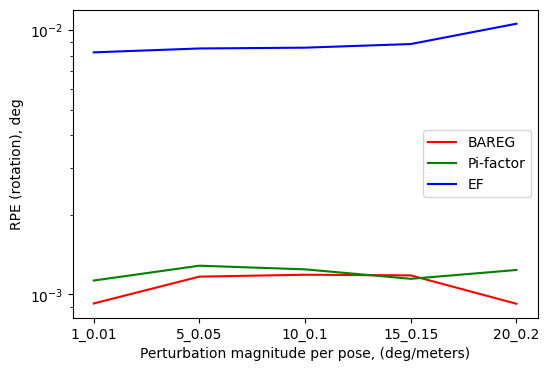

C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will 

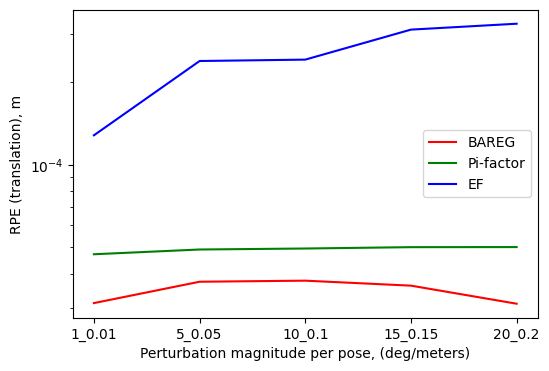

C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will 

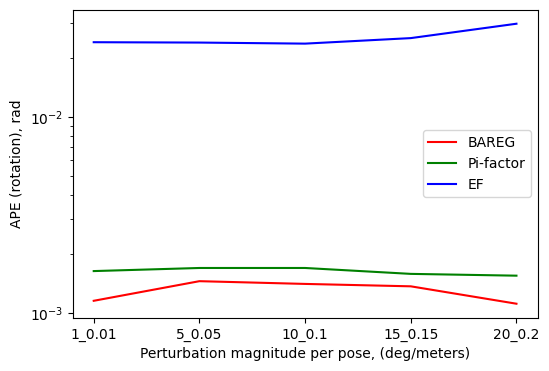

C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\743787268.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will 

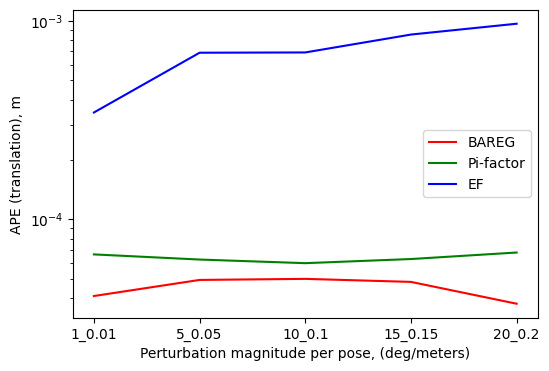

C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will 

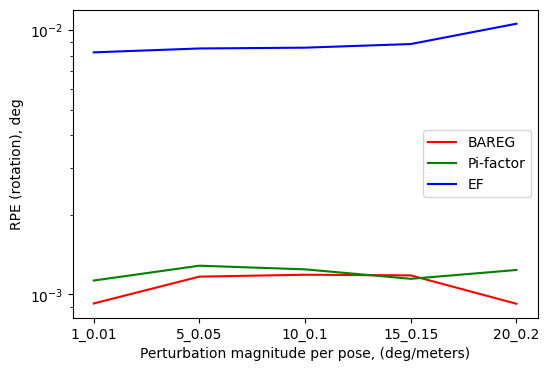

C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will 

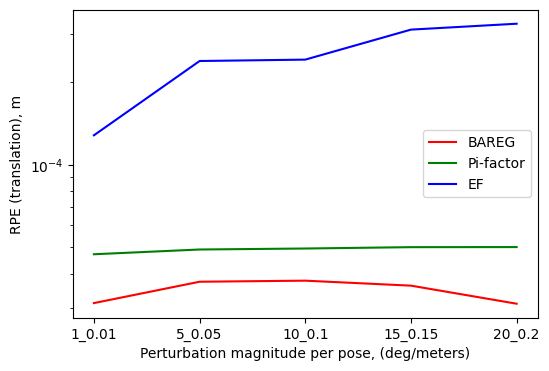

C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will 

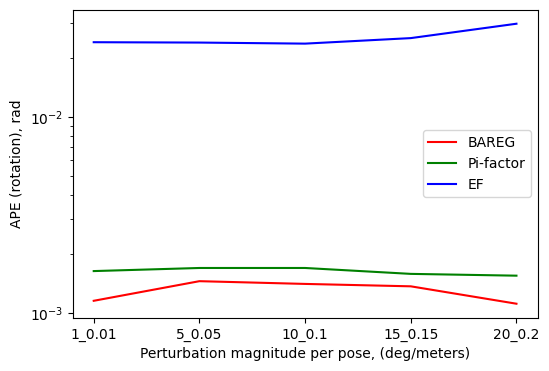

C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
C:\Users\dimaj\AppData\Local\Temp\ipykernel_4300\190755569.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will 

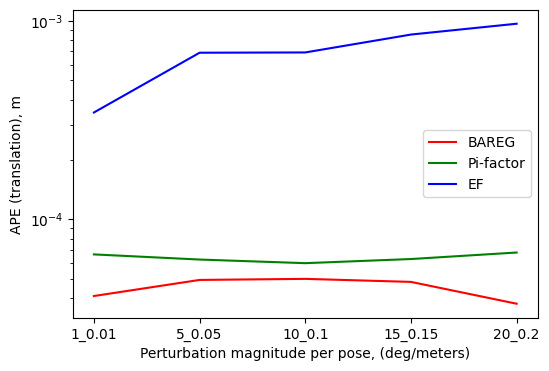

In [14]:
metric_names = {
    'rpe_rotation': 'RPE (rotation), deg',
    'rpe_translation': 'RPE (translation), m',
    'ape_rotation': 'APE (rotation), rad',
    'ape_translation': 'APE (translation), m',
}

df = df_stat

colors = ['r', 'g', 'b', 'y']

for metric_name in metric_names:
    plt.figure(figsize=(6, 4))
    for i, solver in enumerate(solvers):
        stat = []
        d = df[df['solver'] == solver].groupby(['pose_perturbation'], as_index=False).quantile(0.5)
        for perturbation in perturbations:
            stat.append(d[d['pose_perturbation'] == str(perturbation)][metric_name])

        stat = np.array(stat)
        if metric_name.endswith("rotation"):
            plt.plot([str(perturbation) for perturbation in perturbations], stat * 180 / np.pi, '{0}-'.format(colors[i]))
        else:
            plt.plot([str(perturbation) for perturbation in perturbations], stat, '{0}-'.format(colors[i]))

    plt.xlabel('Perturbation magnitude per pose, (deg/meters)')
    plt.ylabel(metric_names[metric_name])
    plt.legend(['BAREG', 'Pi-factor', 'EF'])
    plt.semilogy()
    plt.show()